In [39]:
import polars as pl
import numpy as np
import math, json
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams.update({
        'font.family': 'serif',
        "font.serif": 'Times',
        'font.size': 15,
        'text.usetex': True,
        'pgf.rcfonts': False,
        'text.latex.preamble': r'\usepackage{amsmath}'
})

color_M1 = '#7BBE76'
color_M2 = '#0087AC'
color_M3 = '#323B81'

color_C1 = '#FFC913'
color_C2 = '#F20052'
color_C3 = '#8B1F69'

warmup_time = 5.0
num_runs = 15
v = '019'
per = 0
num_malicios = 60

results_path = '/home/manav/uav-position-verification-simulator'


In [40]:
def calculate_confidence_interval(data, confidence=.95):
    n = len(data)
    m = np.mean(data)
    std_dev = scipy.stats.sem(data)
    h = std_dev * scipy.stats.t.ppf((1 + confidence) / 2, n - 1)
    return [m, h]

In [41]:
def get_summary(fname):
    with open(fname, 'r') as f:
        return json.load(f)

In [42]:
def get_success_rate_for_li(method, lying_intensity):
    success_rates = []

    #malicious_nodes = list(range(0, 500, 5))
    for r in range(num_runs):
        try:
            summary = get_summary(f'{results_path}/res/v{v}/summary-{method}_l{lying_intensity}_m{num_malicios}_per{per}_r{r}.json')
            num_received = summary['num_malicious_packets_received']
            num_detected = summary['num_malicious_detected']
            success_rates.append(num_detected / num_received)
        except:
            pass

    if len(success_rates) == 0:
        return (0,0)      
        
    [m,h] = calculate_confidence_interval(success_rates)
    return (m,h)

def get_success_rates(method, lying_intensities):
    means = []
    cis = []
    for l in lying_intensity:
        (m,ci) = get_success_rate_for_li(method, l)
        means.append(m)
        cis.append(ci)

    return (np.array(means), np.array(cis))




In [43]:
# lying_intensity = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 75, 100, 125, 150, 175, 200, 300, 400, 500]
lying_intensity = np.arange(0,505,5)

ART, ART_CI = get_success_rates('ART', lying_intensity)
MGT, MGT_CI = get_success_rates('MGT', lying_intensity)

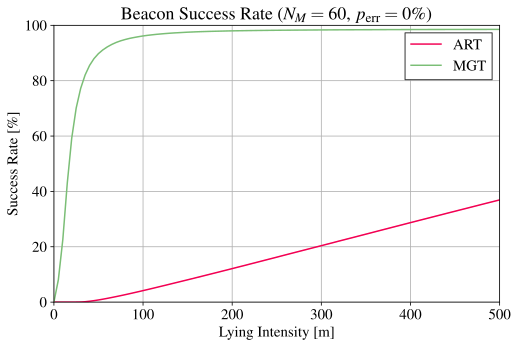

In [44]:
ART_COLOR = color_C2
MGT_COLOR = color_M1
PEPT_COLOR = color_M2
REPT_COLOR = color_C1

fig, ax = plt.subplots(figsize=(8,5))

progress = (1-np.arange(0, 61) / 60) * 100
ax.plot(lying_intensity, ART * 100, label="ART", color=ART_COLOR)
ax.fill_between(lying_intensity, (ART - ART_CI) * 100, (ART + ART_CI) * 100, facecolor=ART_COLOR, interpolate=True, alpha=0.2)

ax.plot(lying_intensity, MGT * 100, label="MGT", color=MGT_COLOR)
ax.fill_between(lying_intensity, (MGT - MGT_CI) * 100, (MGT + MGT_CI) * 100, facecolor=MGT_COLOR, interpolate=True, alpha=0.2)

ax.set_ylim([0, 100])
ax.set_xlim([0, 500])

ax.set_ylabel('Success Rate [\%]')
ax.set_xlabel('Lying Intensity [m]')
ax.grid()

plt.title(f'Beacon Success Rate ($N_M= {num_malicios}$, $p_\mathrm{{err}} = {per}$\%)')

leg = plt.legend(fancybox=False, framealpha=1.0)
leg.get_frame().set_edgecolor('#333')

plt.show()

fig.savefig(f"../figures/packet_success_rate_m{num_malicios}_per{per}_v{v}.pdf", dpi=500, bbox_inches='tight', pad_inches=0.01)
fig.savefig(f"../figures/packet_success_rate_m{num_malicios}_per{per}_v{v}.png", dpi=500, bbox_inches='tight', pad_inches=0.01)

In [45]:
ART[lying_intensity == 55]

array([0.01060707])

In [46]:
MGT[lying_intensity == 500]

array([0.98534404])